In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import re
import string
import random

In [4]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    |   Pack

True

In [5]:
with open("/kaggle/input/games-of-thrones/game_of_thrones.txt" , 'r') as file:
    text = file.readlines()


In [6]:
text[:2]

['A Song of Ice and Fire\n', '\n']

In [7]:
corpus = []
for line in text:
    temp = line.split('.')
    for something in temp:
        corpus.append(something)

In [8]:
data = set(corpus)

In [9]:
dataset = pd.DataFrame(data,  columns=["text"] )

In [10]:
dataset = dataset[dataset['text'].map(lambda x: len(x.split()) > 2)]

In [11]:
dataset.shape

(23143, 1)

In [12]:
dataset.head()

,text
1,I should welcome the chance to try my own ste...
2,"Unless he took the whole inn, the word would ..."
3,All the best swords have names
4,"Still, Tyrion had been unable to silence himself"
5,"He spoke to one of the black brothers, an ol..."


In [13]:
def refine(text):
    text = text.lower()
    text = re.sub(re.compile('https?://\S+|www\.\S+|\d+|<.*?>'), '', text)
    text = nltk.word_tokenize(text)
    return (' '.join(text))

In [14]:
dataset['text'] = dataset['text'].apply(refine)

In [15]:
processed_data = dataset.copy()

In [16]:
dataset

,text
1,i should welcome the chance to try my own stee...
2,"unless he took the whole inn , the word would ..."
3,all the best swords have names
4,"still , tyrion had been unable to silence himself"
5,"he spoke to one of the black brothers , an old..."
...,...
23852,no one moving
23853,bolton does not concern me
23854,"fear cuts deeper than swords , she told hersel..."
23856,thick-fingered hands unfastened helm from gorg...


In [17]:
dataset['text'] = dataset['text'].map(lambda x: 'sos ' + x + ' eos')

In [18]:
dataset

,text
1,sos i should welcome the chance to try my own ...
2,"sos unless he took the whole inn , the word wo..."
3,sos all the best swords have names eos
4,"sos still , tyrion had been unable to silence ..."
5,"sos he spoke to one of the black brothers , an..."
...,...
23852,sos no one moving eos
23853,sos bolton does not concern me eos
23854,"sos fear cuts deeper than swords , she told he..."
23856,sos thick-fingered hands unfastened helm from ...


In [19]:
sent_len = dataset['text'].map(lambda x: len(x.split()))

In [20]:
max(sent_len)

135

In [21]:
def tokenization(text):
    tokens = Tokenizer()
    tokens.fit_on_texts(text)
    input_seq = tokens.texts_to_sequences(text)

    return input_seq, tokens

In [22]:
features, tokens = tokenization(dataset['text'])

In [23]:
features[:5]

[[1, 14, 177, 1161, 3, 964, 5, 859, 31, 176, 229, 203, 62, 106, 91, 2],
 [1,
  1270,
  8,
  122,
  3,
  936,
  1162,
  3,
  290,
  37,
  1224,
  5,
  1088,
  3,
  788,
  28,
  38,
  220,
  2],
 [1, 40, 3, 377, 316, 36, 874, 2],
 [1, 133, 73, 16, 64, 3722, 5, 562, 154, 2],
 [1,
  8,
  596,
  5,
  51,
  7,
  3,
  96,
  362,
  86,
  95,
  54,
  21,
  6,
  839,
  63,
  4,
  6,
  1791,
  570,
  2]]

In [24]:
vocab = len(tokens.word_index) + 1
vocab

11793

In [25]:
input_feature = [x[:-1] for x in features]
input_feature[:3]

[[1, 14, 177, 1161, 3, 964, 5, 859, 31, 176, 229, 203, 62, 106, 91],
 [1,
  1270,
  8,
  122,
  3,
  936,
  1162,
  3,
  290,
  37,
  1224,
  5,
  1088,
  3,
  788,
  28,
  38,
  220],
 [1, 40, 3, 377, 316, 36, 874]]

In [26]:
output_feature = [x[1:] for x in features]
output_feature[:3]

[[14, 177, 1161, 3, 964, 5, 859, 31, 176, 229, 203, 62, 106, 91, 2],
 [1270,
  8,
  122,
  3,
  936,
  1162,
  3,
  290,
  37,
  1224,
  5,
  1088,
  3,
  788,
  28,
  38,
  220,
  2],
 [40, 3, 377, 316, 36, 874, 2]]

In [27]:
seq_len = 60

In [28]:
def pad(seq):
    padded = pad_sequences(seq, padding = 'post', maxlen=seq_len)
    padded = tf.convert_to_tensor(padded)
    return padded

In [29]:
input_data = pad(input_feature)
input_data

<tf.Tensor: shape=(23143, 60), dtype=int32, numpy=
array([[   1,   14,  177, ...,    0,    0,    0],
       [   1, 1270,    8, ...,    0,    0,    0],
       [   1,   40,    3, ...,    0,    0,    0],
       ...,
       [   1,  260, 2192, ...,    0,    0,    0],
       [   1,  360, 3183, ...,    0,    0,    0],
       [   1,  333,  430, ...,    0,    0,    0]], dtype=int32)>

In [30]:
output_data = pad(output_feature)
output_data

<tf.Tensor: shape=(23143, 60), dtype=int32, numpy=
array([[  14,  177, 1161, ...,    0,    0,    0],
       [1270,    8,  122, ...,    0,    0,    0],
       [  40,    3,  377, ...,    0,    0,    0],
       ...,
       [ 260, 2192, 2214, ...,    0,    0,    0],
       [ 360, 3183,  195, ...,    0,    0,    0],
       [ 333,  430, 4709, ...,    0,    0,    0]], dtype=int32)>

In [31]:
vocab = vocab
seq_len = input_data.shape[1]
embed_dim = 60
hidden_dim = 64
num_heads = 4
num_blocks = 4
head_dim = embed_dim//num_heads

In [32]:
class positionalEncoding(tf.keras.layers.Layer):
    def __init__(self, vocab, sequence, embed_dim, **kwargs):
        super().__init__(**kwargs)

        self.vocab = vocab
        self.sequence = sequence
        self.embed_dim = embed_dim
        self.embeddings = tf.keras.layers.Embedding(input_dim = self.vocab, output_dim = self.embed_dim, input_length = self.sequence)
        self.positional_encoding = tf.keras.layers.Embedding(self.sequence, self.embed_dim)

    def call(self, inputs):
        pos_ids = tf.range(self.sequence)
        embedded = self.embeddings(inputs)
        position = self.positional_encoding(pos_ids)
        final = embedded + position

        return final

In [33]:
ps = positionalEncoding(vocab, seq_len, embed_dim)
input_embed = ps(input_data)

In [34]:
input_embed

<tf.Tensor: shape=(23143, 60, 60), dtype=float32, numpy=
array([[[-5.1251281e-02,  4.9553141e-03, -9.0953335e-04, ...,
         -3.5452295e-02,  4.9188234e-02, -6.7888059e-02],
        [-3.5316359e-02,  9.6080080e-03, -1.7287698e-02, ...,
          2.8739009e-02,  3.1619780e-03, -2.2128856e-02],
        [ 2.0232052e-05,  5.7185575e-02,  4.4765852e-02, ...,
         -5.7053246e-02, -6.4442270e-03,  3.4208868e-02],
        ...,
        [-6.0936093e-02,  5.8474824e-02,  7.2437257e-02, ...,
         -6.9415942e-03, -6.7972004e-02, -4.0552165e-02],
        [ 2.3774326e-02, -5.3462423e-03,  3.8795795e-02, ...,
          7.8680918e-02, -4.9422909e-02, -4.4115178e-02],
        [-7.2983019e-03,  2.3332272e-02,  9.1164351e-02, ...,
          1.7886277e-02, -5.2878320e-02,  2.5791641e-02]],

       [[-5.1251281e-02,  4.9553141e-03, -9.0953335e-04, ...,
         -3.5452295e-02,  4.9188234e-02, -6.7888059e-02],
        [ 2.3169532e-02,  4.4785082e-02,  4.5366652e-02, ...,
         -2.8958082e-02,  

In [35]:
class causal_masking(tf.keras.layers.Layer):

    def __init__(self,  **kwargs):
        super().__init__(**kwargs)

    def call(self, sequence):
        mask = tf.linalg.band_part(tf.ones((1, sequence, sequence)), -1, 0)
        return mask

In [36]:
cm = causal_masking()
mask = cm(seq_len)

In [37]:
mask

<tf.Tensor: shape=(1, 60, 60), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

In [38]:
class decoder_block(tf.keras.layers.Layer):

    def __init__(self, num_heads, vocab, sequence, embed_dim, hidden_dim, dropout_rate = 0.01, **kwargs):
        super().__init__(**kwargs)

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads, embed_dim, dropout = dropout_rate)
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.drop1 = tf.keras.layers.Dropout(rate = dropout_rate)
        self.drop2 = tf.keras.layers.Dropout(rate = dropout_rate)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim,activation="relu"),
                                    tf.keras.layers.Dense(hidden_dim,activation="relu"),
                                    tf.keras.layers.Dense(embed_dim,activation="relu"),
                                    tf.keras.layers.Dropout(dropout_rate)])

    def call(self, inputs, mask, training = True):

        mha_out = self.mha(inputs, inputs, inputs, mask)
        drop1 = self.drop1(mha_out, training = training)
        norm1 = self.norm1(inputs + drop1)

        ffn_out = self.ffn(norm1)
        drop2 = self.drop2(ffn_out, training = training)
        norm2 = self.norm2(norm1 +  drop2)

        return norm2

In [39]:
class decoder(tf.keras.layers.Layer):

    def __init__(self, num_heads, vocab, sequence, embed_dim, hidden_dim, num_blocks, dropout_rate = 0.01, **kwargs):
        super().__init__()

        self.sequence = sequence
        self.pos_enc = positionalEncoding(vocab, sequence, embed_dim)
        self.masking = causal_masking()
        self.decoder = [decoder_block(num_heads, vocab, sequence, embed_dim, hidden_dim) for i in range(num_blocks)]
        self.add = tf.keras.layers.Add()

    def call(self, inputs):
        emb = self.pos_enc(inputs)
        masked = self.masking(self.sequence)
        temp = emb

        for blocks in self.decoder:
            emb = blocks(emb, masked)
            emb = self.add([temp, emb])
            temp = emb

        return emb

In [40]:
class gpt_model(tf.keras.Model):

    def __init__(self,num_heads, vocab, sequence, embed_dim, hidden_dim, num_blocks, **kwargs):
        super().__init__(**kwargs)

        self.decoder = decoder(num_heads, vocab, sequence, embed_dim, hidden_dim, num_blocks)

        self.final_layer = tf.keras.layers.Dense(vocab, activation='relu')
        self.softmax = tf.keras.layers.Softmax(axis = -1)

    def call(self, inputs):

        dec_out = self.decoder(inputs)

        densed = self.final_layer(dec_out)
        softmaxed = self.softmax(densed)

        return softmaxed

In [41]:
gpt = gpt_model(num_heads, vocab, seq_len, embed_dim, hidden_dim, num_blocks)
gpt_out = gpt(input_data[:1])

In [42]:
gpt.summary()

Model: "gpt_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder (decoder)           multiple                  993516    
                                                                 
 dense_12 (Dense)            multiple                  719373    
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 1,712,889
Trainable params: 1,712,889
Non-trainable params: 0
_________________________________________________________________


In [43]:
comp = gpt.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

In [44]:
calls = tf.keras.callbacks.EarlyStopping(patience = 5, verbose = True)

In [ ]:
fit = gpt.fit(input_data, output_data , epochs=50, batch_size=32, verbose=True, callbacks=calls)

In [46]:
fit = gpt.fit(input_data, output_data , epochs=10, batch_size=32, verbose=True, callbacks=calls)

Epoch 1/10
724/724 [==============================] - 27s 38ms/step - loss: 1.0013 - accuracy: 0.8567
Epoch 2/10
724/724 [==============================] - 27s 38ms/step - loss: 0.9987 - accuracy: 0.8572
Epoch 3/10
724/724 [==============================] - 27s 37ms/step - loss: 0.9976 - accuracy: 0.8574
Epoch 4/10
724/724 [==============================] - 27s 38ms/step - loss: 0.9950 - accuracy: 0.8580
Epoch 5/10
724/724 [==============================] - 27s 37ms/step - loss: 0.9936 - accuracy: 0.8583
Epoch 6/10
724/724 [==============================] - 27s 38ms/step - loss: 0.9928 - accuracy: 0.8584
Epoch 7/10
724/724 [==============================] - 27s 37ms/step - loss: 0.9916 - accuracy: 0.8587
Epoch 8/10
724/724 [==============================] - 27s 38ms/step - loss: 0.9908 - accuracy: 0.8588
Epoch 9/10
724/724 [==============================] - 27s 38ms/step - loss: 0.9884 - accuracy: 0.8592
Epoch 10/10
724/724 [==============================] - 27s 38ms/step - loss: 0.987

In [47]:
fit = gpt.fit(input_data, output_data , epochs=20, batch_size=32, verbose=True, callbacks=calls)

Epoch 1/20
724/724 [==============================] - 28s 38ms/step - loss: 0.9862 - accuracy: 0.8596
Epoch 2/20
724/724 [==============================] - 27s 37ms/step - loss: 0.9844 - accuracy: 0.8599
Epoch 3/20
724/724 [==============================] - 27s 37ms/step - loss: 0.9834 - accuracy: 0.8601
Epoch 4/20
724/724 [==============================] - 27s 37ms/step - loss: 0.9821 - accuracy: 0.8604
Epoch 5/20
724/724 [==============================] - 27s 38ms/step - loss: 0.9815 - accuracy: 0.8605
Epoch 6/20
724/724 [==============================] - 27s 37ms/step - loss: 0.9806 - accuracy: 0.8605
Epoch 7/20
724/724 [==============================] - 27s 37ms/step - loss: 0.9788 - accuracy: 0.8610
Epoch 8/20
724/724 [==============================] - 27s 37ms/step - loss: 0.9778 - accuracy: 0.8612
Epoch 9/20
724/724 [==============================] - 27s 38ms/step - loss: 0.9772 - accuracy: 0.8613
Epoch 10/20
724/724 [==============================] - 27s 38ms/step - loss: 0.976

In [50]:
gpt.save_weights("tg_model")

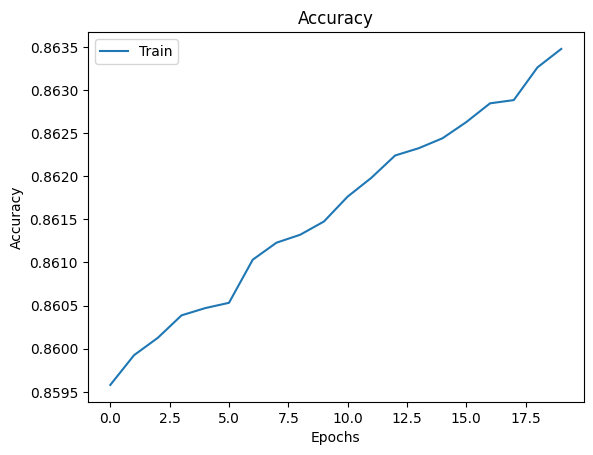

In [52]:
plt.plot(fit.history['accuracy'])
plt.title('Accuracy')
plt.legend(['Train'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

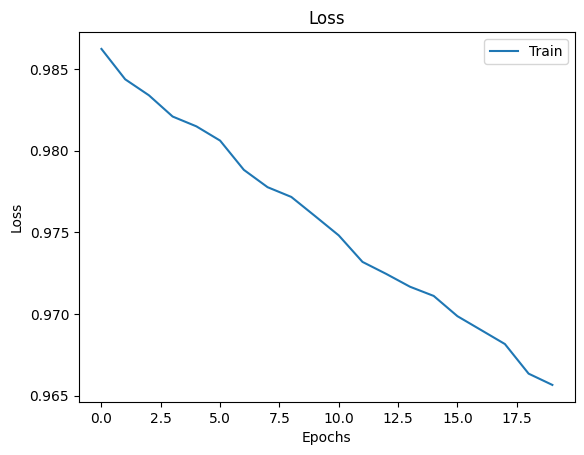

In [53]:
plt.plot(fit.history['loss'])
plt.title('Loss')
plt.legend(['Train'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [71]:
def prepare_inputs(sentences):
    input_tokenized = tokens.texts_to_sequences(sentences)
    input_padded = pad(input_tokenized)
    return input_padded

In [58]:
end = ["<EOS>"]
end = tokens.texts_to_sequences(end)
end = tf.convert_to_tensor(end)
end = end[0]
end

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>

In [90]:
d = ["sos ser barristan"]
dt = prepare_inputs(d)
pred = np.argmax(gpt.predict(dt, verbose=0), axis = -1)[0,0]
d[0] = d[0] + " " + (tokens.sequences_to_texts(np.array([[pred]])))[0]

for i in range(1, seq_len):
    dt = prepare_inputs(d)
    pred = np.argmax(gpt.predict(dt, verbose=0), axis = -1)[0,i]
    d[0] = d[0] + " " + (tokens.sequences_to_texts(np.array([[pred]])))[0]
    print(" ".join(d))
    if pred == end:
        break
            

sos ser barristan the vardis
sos ser barristan the vardis was
sos ser barristan the vardis was king
sos ser barristan the vardis was king said
sos ser barristan the vardis was king said as
sos ser barristan the vardis was king said as eos


# Thanks